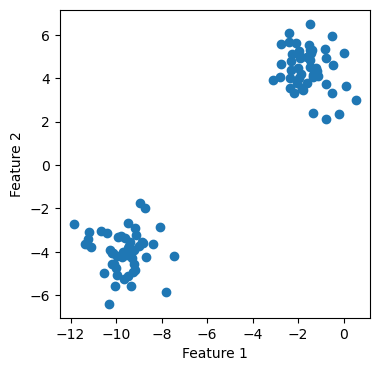

In [17]:
from sklearn.datasets import make_blobs, make_circles
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(12345)

fig, ax = plt.subplots(1, figsize = (4, 4))
X, y = make_blobs(n_samples=100, n_features=2, 
                                centers=2, random_state=1)

a = ax.scatter(X[:, 0], X[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

This data looks a lot like the kind of data that we used for classification. This time, however, we **ignore $\vy$** (imagine our data didn't come with any labels). We can still look at the plot and see that it apparently contains two groups or "clusters" of data. The **clustering** task is identify clusters that "fit" the data well, according to some criterion of "fit." The k-means algorithm is one algorithm that attempts to perform this task. On this particular data, k-means does pretty well: 

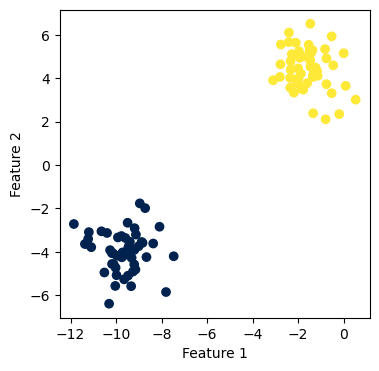

In [18]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 2)
km.fit(X)                    # NOTE: fit does not use y!! 

clusters = km.predict(X)

fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1], c = clusters, cmap = plt.cm.cividis)
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

Note that what "pretty well" means here is subjective; because we don't have any labels $\vy$, we can't say that the clustering found by the model is "good" according to any objective criterion. Often we just have to eyeball the groups, or attempt to interpret them based on some prior knowledge we might have about the data. 

## K-Means Clustering

In the k-means algorithm, we divide the data into clusters by finding a *cluster centroid* for each. The centroid is the mean feature value in each cluster, and gives a summary of the location of the cluster. Suppose we have $\ell$ clusters, and let $\vm_j \in \R^p$, $j = 1,\ldots,\ell$ be the proposed cluster centroids, which we can collect into a matrix $\mM \in \R^{\ell \times p}$. To associate each data point $\vx_i$ to a cluster centroid $\vm_j$, we also posit a vector $\vz \in [\ell]^n$ of cluster labels, one for each point. If $z_i = j$, this says that "point $i$ belongs to cluster $j$."[The label vector $\vz$ might look superficially similar to the target vector $\vy$ in classification problems. The difference here is that we are free to set $\vz$ as part of the learning process.]{.aside} 

Our aim is to find the cluster centroids $\vm_j$, $j = 1,\ldots, \ell$ and labels $\vz$ that separate the data "well." What does "well" mean? As usual, in order to define this, we need to define a loss function. We're outside our usual supervised framework, so we need our loss function to come from a different place. The standard loss function for k-means comes from a simple intuition: a good clustering is one in which the points in each group are close to their group centroid. This leads us to the problem 

[In this optimization, we we assume that $\mM \in \R^{\ell \times p}$. The problem of how to choose a good value of $\ell$, the number of clusters, is a more challenging one that we won't discuss in this course.]{.aside}
$$
\hat{\mM}, \hat{\vz} = \argmin_{\mM,\;\vz} \sum_{i = 1}^n \norm{\vx_i - \vm_{z_i}}^2\;.
$${#eq-k-means-objective}

This is a nice mathematical formulation with a deep, dark secret: it's not convex! This means that we can't expect to find the "best" $\hat{\mM}$ and $\hat{\vz}$; we can only find "pretty good ones," where "pretty good" means "locally optimal." There's a beautifully simple algorithm that we can use to perform this task: 

In [20]:
import numpy as np
from sklearn.metrics import pairwise_distances

def k_means_step(X, M, z):
    # compute the distances between all points and all centroids
    D = pairwise_distances(X, M)
    # each point's new group is its closest centroid
    z = np.argmin(D, axis = 1)
    # each centroid's new value is the mean of all the points in its group
    
    for j in range(M.shape[0]):
        M[j,:] = X[z == j].mean(axis = 0)
        
    return M, z

def k_means(X, ell):

    # random initialization
    n, p = X.shape
    M = np.random.rand(ell, p)
    z_prev = np.random.randint(0, ell, n)
    done = False

    # do k_means_step until z stops changing
    while not done: 
        M, z = k_means_step(X, M, z_prev)
        if np.all(z_prev == z):
            done = True
        z_prev = z
    
    # return the centroid matrix and cluster labels
    return M, z

Let's run this algorithm and plot the results. 


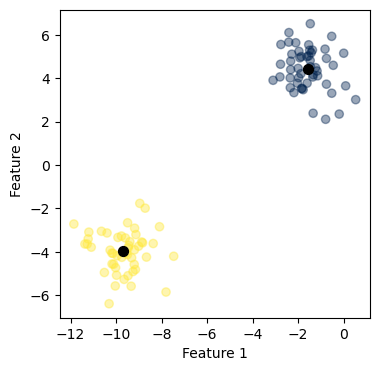

In [21]:
#| fig-cap: Original data is shown in blue and yellow according to the cluster learned via the k-means algorithm. Centroids of each cluster are shown in black. 

M, z = k_means(X, 2)

fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1], c = z, alpha = 0.4, cmap = plt.cm.cividis)
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

ax.scatter(M[:,0], M[:,1], s = 50, color = "black")

[The implementation of the algorithm above doesn't handle an important issue: if one of the centroids is far away from *all* of the clusters and therefore gets no points assigned to it. This leads to errors because it's impossible to compute a centroid $\vm$ for those clusters. A complete implementation would need to handle this issue, but we won't worry about it here.]{.aside} 

Looks ok! We have segmented the data into two clusters and found reasonable looking centroids, even though we didn't begin with any true labels.

The following result is the fundamental theorem for k-means: 

::: {.callout-note}

::: {#thm-k-means}

## "K-means works"

Each iteration of `k-means-step` does not increase the objective function in @eq-k-means-objective, provided that every cluster centroid is associated to at least one point. Furthermore, in this case, the k-means algorithm converges after a finite number of steps. 
:::

:::

## Laplacian Spectral Clustering

K-means is a useful algorithm with an important limitation: it works best when the data is approximately linearly separable! So, we wouldn't expect k-means to do very well at all if we wanted to separate the two rings in a data set like this: 

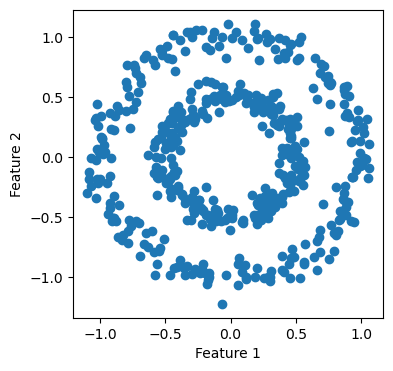

In [22]:
np.random.seed(1234)

n = 500
X, y = make_circles(n_samples=n, shuffle=True, noise=0.07, random_state=None, factor = 0.5)

fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

Let's check: 

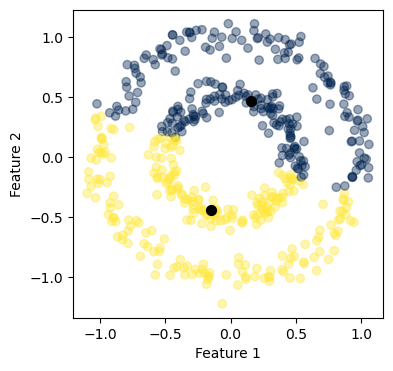

In [23]:
M, z = k_means(X, 2)

fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1], c = z, alpha = 0.4, cmap = plt.cm.cividis)
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

ax.scatter(M[:,0], M[:,1], s = 50, color = "black")

You can see what k-means was going for here, but the result doesn't distinguish the two features that most of us would pick out by eye. 

We'll now develop *Laplacian spectral clustering*, a clustering method that uses matrix eigenvectors to cluster the data. Spectral clustering is a very beautiful and effective technique for nonlinear clustering of data. It has two primary limitations: it is most effective for binary clustering, and it can be computationally expensive for larger data sets. 

## Nearest-Neighbors Graph

Laplacian clustering begins by computing the $k$-nearest-neighbors graph. In the $k$-nearest-neighbors graph, we draw a connecting edge between each point and the $k$ points that are nearest to it in distance. 

In [24]:
from sklearn.neighbors import NearestNeighbors

k = 10
nbrs = NearestNeighbors(n_neighbors = k).fit(X)
A = nbrs.kneighbors_graph().toarray()

A = A + A.T
A[A > 1] = 1

Here, the `i`th row of `A` contains a `1` in each column `j` such that `j` is one of the five nearest neighbors of `i`. The following function will draw this graph for us: 

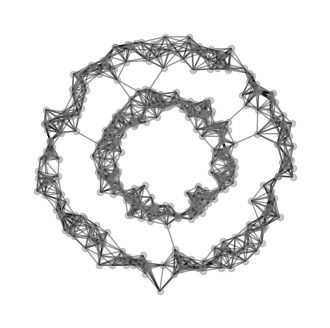

In [25]:
import networkx as nx

def plot_graph(X, A, z = None, ax = None, show_edge_cuts = True):
    G = nx.from_numpy_array(A)
    if z is None:
        nx.draw(G, pos = X, alpha = .4, node_color = "grey", node_size = 20, ax = ax)
    else: 
        if show_edge_cuts:
            colors = ["red" if z[i] != z[j] else "grey" for i, j in G.edges()]
            widths = [2 if z[i] != z[j] else 1 for i, j in G.edges()]
        else:
            colors = "black"
            widths = 1
        
        nx.draw(G, pos = X, alpha = .4, node_color = z, node_size = 20, edge_color = colors, width = widths, ax = ax, cmap=plt.cm.cividis)

    plt.gca().set(xlabel = "Feature 1", ylabel = "Feature 2")
fig, ax = plt.subplots(figsize = (4, 4))
plot_graph(X, A)

We can now frame our task as one of finding the "pieces" of this graph. Defining a "piece" of a graph mathematically takes a bit of work. To think about this problem mathematically, let's first define a label vector $\vz \in [0,1]^n$. As usual, our machine learning problem is actually a mathematical minimization problem: we want to define an objective function $f$ such that $f(\vz)$ is small when the labels of $\vz$ are "good."

## Cut-Based Clustering

A reasonable first pass at this problem is to define a clustering to be good when it doesn't "cut" too many edges. An edge is "cut" if it has two nodes in different clusters. For example, here are two possible clusterings, with the edges cut by each clustering shown in red. 

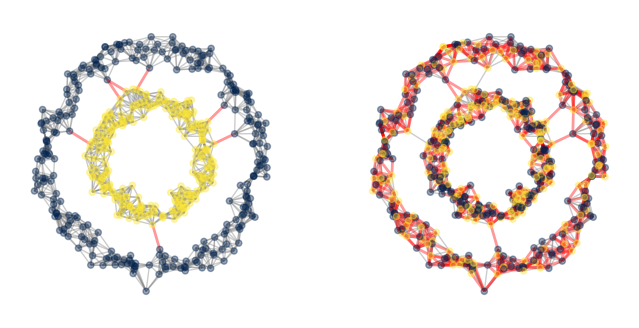

In [26]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 4))
y_bad = np.random.randint(0, 2, n)

plot_graph(X, A, z = y, ax = axarr[0])
plot_graph(X, A, z = y_bad, ax = axarr[1])

The righthand plot has many more red edges, which connect nodes in two different proposed clusters. In contrast, the lefthand plot has many fewer. 

Here are the cut values of these two clusterings: 

In [27]:
# implement cut
    
def cut(A, z): # number of edges in A cut by z
    D = pairwise_distances(z.reshape(-1, 1))
    return (A*D).sum()/2
    
print(f"good labels cut = {cut(A, z = y)}") 
print(f"bad labels cut = {cut(A, z = y_bad)}") 

good labels cut = 7.0
bad labels cut = 1475.0


So, it might seem as though a good approach would be to minimize the cut value of a label vector. Unfortunately, cut minimization has a fatal flaw: the best cut is always the one that assigns all nodes to the same label! This clustering always achieves a cut score of 0. So, we need to try something different. 

## Normalized Cut

To define a better objective, we need a little notation. The *volume* of cluster $j$ in matrix $\mA$ with clustering vector $\vz$ is defined as 

$$
\vol{j}{\mA}{\vz} = \sum_{i = 1}^n \sum_{i' = 1}^n \one{z_i = j} a_{ii'}
$$

Heuristically, $\vol{j}{\mA}{\vz}$ is the number of edges that have one node in cluster $j$. The *normalized cut objective function* is 

$$
f(\vz, \mA) = \cut{\mA}{\vz}\left(\frac{1}{\vol{0}{\mA}{\vz}} + \frac{1}{\vol{1}{\mA}{\vz}}\right)
$$

The normcut of our preferable clustering is still better than the random one: 

In [ ]:
# implement vol and normcut

def vol(j, A, z):
    return A[z == j,:].sum()

print(f"good labels normcut = {normcut(A, z = y)}") 
print(f"bad labels normcut = {normcut(A, z = y_bad)}") 

::: {.callout-important}

How do the $\frac{1}{\vol{j}{\mA}{\vz}}$ terms stop the normcut from favoring the clustering in which one cluster contains no nodes? 

:::



## Spectral Approximation

Great! How do we choose $\vz$ to minimize the normcut? 

::: {.callout-note}

::: {#thm-spectral-hard}

The problem of finding a binary vector $\vz \in \{0,1\}^n$ that minimizes the normcut objective is NP-hard. 

:::

:::

Whoops! In fact, we can't minimize the normcut exactly, so we need to do so approximately. 

Here is the trick. Suppose that we have a binary clustering vector $\vz$. We're going to associate $\vz$ with a modified clustering vector $\tilde{\vz}$ with entries

$$
\tilde{z}_i = \begin{cases}
    &\frac{1}{\vol{0}{\mA}{\vz}} \quad z_i = 0 \\ 
    - &\frac{1}{\vol{1}{\mA}{\vz}} \quad z_i = 1\;.
\end{cases}
$$

A direct mathematical calculation then shows that we can write the normcut objective as $f(\vz) = \tilde{f}({\tilde{\vz}})$, where 

$$
\tilde{f}({\tilde{\vz}}) = \frac{\tilde{\vz}^T(\mD - \mA)\tilde{\vz}}{\tilde{\vz}^T\mD\tilde{\vz}}\;,
$${#eq-rayleigh-quotient}

where 

$$
\mD = \left[\begin{matrix} \sum_{i = 1}^n a_{i1} & & & \\ 
    & \sum_{i = 1}^n a_{i2} & & \\ 
    &  & \ddots & \\ 
    & & & \sum_{i = 1}^n a_{in}
\end{matrix}\right]\;.
$$

Additionally, we have 
$$
\tilde{\vz}^T\mD \vone = 0\;,
$${#eq-balance}
where $\vone$ is the vector containing all 1s. Heuristically, @eq-balance says that cluster 0 and cluster 1 contain roughly the same number of *edges* within them. 

[This cheat is common enough that it has a name: we call it the *spectral relaxation*.]{.aside}

At this stage we do a cheat: we *forget* about the requirement that $\tilde{\vz}$ have the form we stated above. Instead, we simply solve the optimization problem 

$$
\begin{aligned}
\tilde{\vz} =& \argmin_{\tilde{\vz}} \frac{\tilde{\vz}^T(\mD - \mA)\tilde{\vz}}{\tilde{\vz}^T\mD\tilde{\vz}} \\ 
& \text{such that }\tilde{\vz}^T\mD \vone = 0
\end{aligned}
$$

A  beautiful theorem from linear algebra states that there is an explicit solution to this problem: $\vz$ should be the eigenvector with the second-smallest eigenvalue of the matrix $\mL = \mD^{-1}[\mD - \mA]$. This matrix $\mL$ is called the *normalized Laplacian*, and it is the reason that this clustering algorithm is called *Laplacian spectral clustering*. 

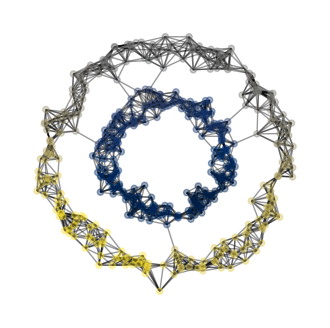

In [28]:
from hidden.spectral import second_laplacian_eigenvector
fig, ax = plt.subplots(figsize = (4, 4))
z_ = second_laplacian_eigenvector(A)
plot_graph(X, A, z = z_, show_edge_cuts = False, ax = ax)

Darker shades correspond to nodes on which the eigenvector is negative, while lighter shades correspond to nodes on which the eigenvector is positive. We can get a final set of cluster labels just by assigning nodes to the cluster depending on the sign of the estimated $\tilde{\vz}$:

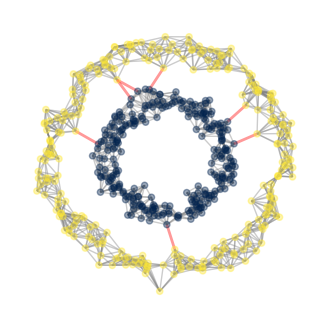

In [30]:
z = z_ > 0
fig, ax = plt.subplots(figsize = (4, 4))
plot_graph(X, A, z, show_edge_cuts = True, ax = ax)

Our method of distinguishing the two rings using Laplacian spectral clustering seems to have worked! Let's try with another data set: 

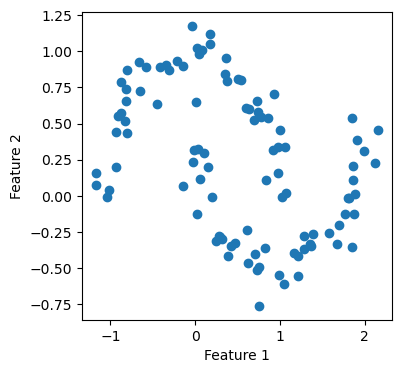

In [31]:
from sklearn.datasets import make_moons

X, z = make_moons(n_samples=100, random_state=1, noise = .1)
fig, ax = plt.subplots(figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

Now we'll use a complete implementation of Laplacian spectral clustering, which you can complete in an optional blog post. 

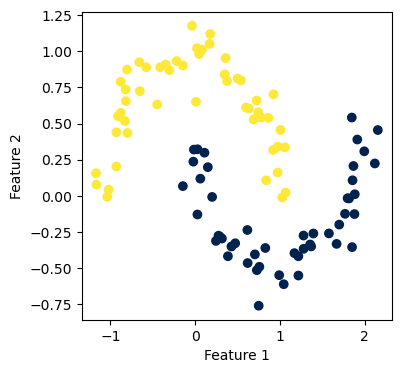

In [32]:
from hidden.spectral import spectral_cluster

fig, ax = plt.subplots(figsize = (4, 4))
z = spectral_cluster(X, n_neighbors = 6)
a = ax.scatter(X[:, 0], X[:, 1], c = z, cmap = plt.cm.cividis)
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

Looks pretty good! Note, however, that we chose a pretty specific value of `n_neighbors`, the number of neighbors to use when forming the nearest-neighbors graph. This is a hyperparameter that needs to be tuned in some way. Unfortunately, cross-validation isn't really an option here, as we don't have a loss function or training data to use for validation purposes. 

The performance of Laplacian spectral clustering can depend pretty strongly on this parameter. In this data set, small values can lead to oddly fragmented clusters, while larger values lead to results that don't look too different from what we might expect from `k-means`: 

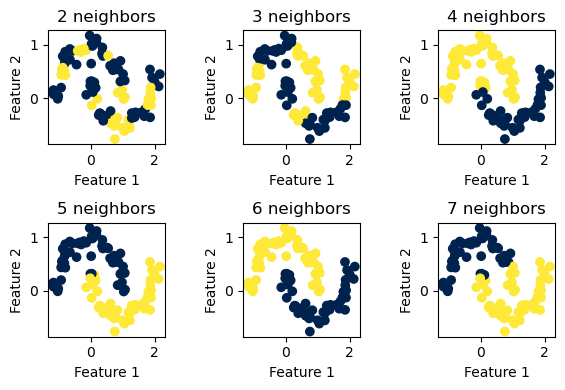

In [33]:
fig, axarr = plt.subplots(2, 3, figsize = (6, 4))

i = 2
for ax in axarr.ravel():
    z = spectral_cluster(X, n_neighbors = i)
    a = ax.scatter(X[:, 0], X[:, 1], c = z, cmap = plt.cm.cividis)
    a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"{i} neighbors")
    i += 1

plt.tight_layout()

As usual, there are ways to address these limitations, but these are beyond our scope for today. 
